<a href="https://www.kaggle.com/code/karan842/pneumonia-detection-with-vgg19-91?scriptVersionId=91802945" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# AI for Medical Diagnoisis:
Computer Vision has a lot of applications in medical diagnosis:
- Dermatology
- Ophthakmology
- Histopathlogy

Perhaps, `X-rays` images are critical for the detection of lung cancer, pneumenia ... 

Steps are: 

- Data pre-processing
- Preprocess images properly for the train, validation and test sets.
- Set-up a pre-trained neural network to make disease predictions on chest X-rays.

# What is Pneumonia?

- Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

- Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

![pneumonia](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSPPW6B1QQMf3UDXkwO3RmJl1qLPPIfuDmX2w&usqp=CAU)

# Importing necessary libraries

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

## Loading the data

In [2]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [3]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


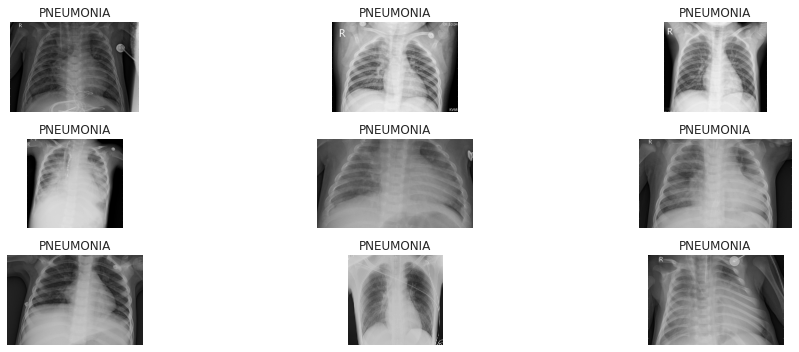

In [4]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

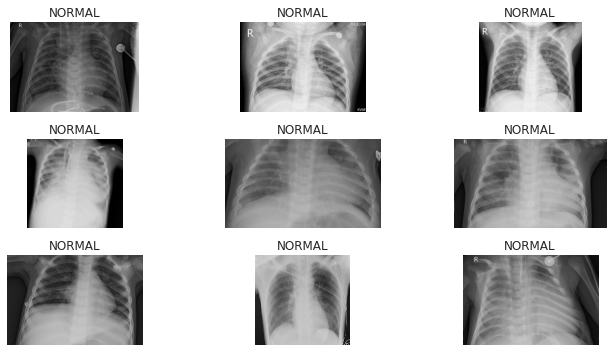

In [5]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [6]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [7]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

Labels are: `0 - NORMAL || 1 - PNEUMONIA`

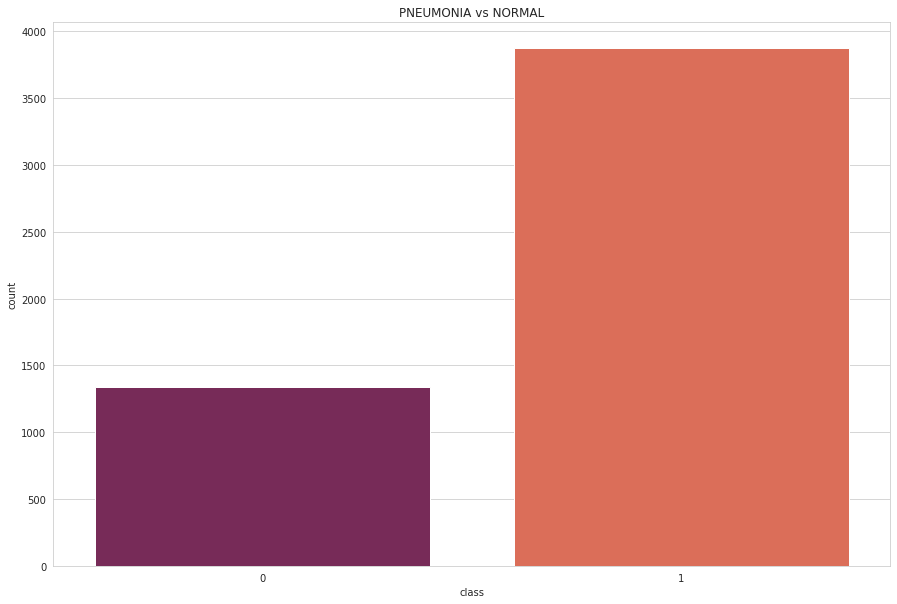

In [8]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

## Data Augmentation
- Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on.

2. Also deal wit imbalances number of data points of the given classes.

In [9]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [10]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=8,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=1,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = img_Datagen.flow_from_directory(test_dir,
                                       batch_size=1,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
img, label = next(train)
img.shape

(8, 256, 256, 3)

# Defining the model
- Using pre-trainied VGG19 model.
- Freezing all the layers of model of train.
- Using Adam as optimizer

In [12]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

2022-04-01 02:29:12.671914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 02:29:12.765910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 02:29:12.766581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 02:29:12.767684: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
# len(validation)/32

In [15]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
#                     callbacks=[early_stopping],
                    batch_size=32)

2022-04-01 02:29:16.333468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-01 02:29:18.146940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 34s 261ms/step - loss: 0.4791 - accuracy: 0.7675 - val_loss: 0.5969 - val_accuracy: 0.6250
Epoch 2/30
100/100 [==============================] - 25s 251ms/step - loss: 0.3768 - accuracy: 0.8238 - val_loss: 0.5949 - val_accuracy: 0.7500
Epoch 3/30
100/100 [==============================] - 23s 232ms/step - loss: 0.3354 - accuracy: 0.8350 - val_loss: 0.7058 - val_accuracy: 0.6250
Epoch 4/30
100/100 [==============================] - 23s 226ms/step - loss: 0.3135 - accuracy: 0.8612 - val_loss: 0.4616 - val_accuracy: 0.7500
Epoch 5/30
100/100 [==============================] - 23s 229ms/step - loss: 0.3046 - accuracy: 0.8562 - val_loss: 0.5208 - val_accuracy: 0.8125
Epoch 6/30
100/100 [==============================] - 22s 218ms/step - loss: 0.2969 - accuracy: 0.8687 - val_loss: 0.4570 - val_accuracy: 0.7500
Epoch 7/30
100/100 [==============================] - 21s 206ms/step - loss: 0.2929 - accuracy: 0.8637 - val_loss: 0.5068 - val_accuracy: 0.7

# Evaluating the VGG19

In [16]:
# Evaluating the model on traina and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

652/652 [==============================] - 121s 185ms/step - loss: 0.2250 - accuracy: 0.9032
Train Loss:  0.225005641579628
Train Accuracy:  0.9031825065612793


In [17]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

624/624 [==============================] - 18s 29ms/step - loss: 0.3146 - accuracy: 0.8830
Test Loss:  0.3146117627620697
Test Accuracy:  0.8830128312110901


Text(0.5, 1.0, 'Accuracy Evolution')

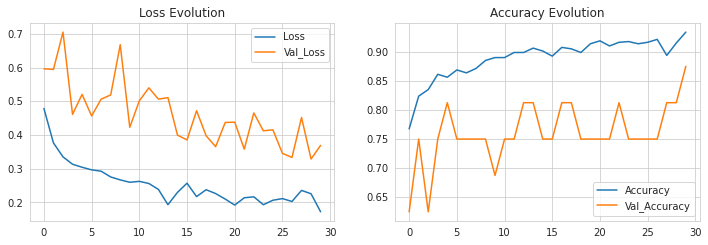

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# MobileNetV2

In [33]:
mobileNet_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in mobileNet_model.layers:
    layer.trainable=False
    
x = mobileNet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=mobileNet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [34]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
#                     callbacks=[early_stopping],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 22s 191ms/step - loss: 0.2888 - accuracy: 0.8675 - val_loss: 0.3064 - val_accuracy: 0.8125
Epoch 2/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2303 - accuracy: 0.9075 - val_loss: 0.2699 - val_accuracy: 0.8125
Epoch 3/30
100/100 [==============================] - 19s 185ms/step - loss: 0.2294 - accuracy: 0.9025 - val_loss: 0.2215 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 18s 181ms/step - loss: 0.1684 - accuracy: 0.9375 - val_loss: 0.2297 - val_accuracy: 0.8750
Epoch 5/30
100/100 [==============================] - 19s 191ms/step - loss: 0.1758 - accuracy: 0.9275 - val_loss: 0.1997 - val_accuracy: 0.8750
Epoch 6/30
100/100 [==============================] - 20s 196ms/step - loss: 0.1516 - accuracy: 0.9325 - val_loss: 0.2063 - val_accuracy: 0.9375
Epoch 7/30
100/100 [==============================] - 19s 185ms/step - loss: 0.1763 - accuracy: 0.9388 - val_loss: 0.2028 - val_ac

In [36]:
# Evaluating the model on traina and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

652/652 [==============================] - 116s 178ms/step - loss: 0.1482 - accuracy: 0.9379
Train Loss:  0.14823195338249207
Train Accuracy:  0.9378834366798401
624/624 [==============================] - 17s 27ms/step - loss: 0.8326 - accuracy: 0.7260

Test loss:  0.8325949311256409
Test Accuracy:  0.7259615659713745


Text(0.5, 1.0, 'Accuracy Evolution')

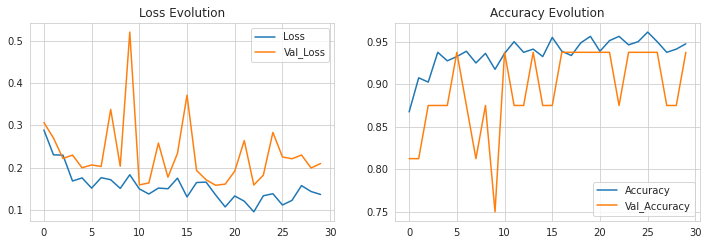

In [37]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [19]:
# from sklearn.metrics import confusion_matrix, classification_report
# pred = model.predict(test)

# print("Confusion matrix")
# cm = confusion_matrix(test.classes, pred>0.5)*100
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
# ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])

In [20]:
# print(cm)

In [21]:
# print("Classification Report: \n")
# print(classification_report(test.classes, pred>0.5))


In [22]:
# from sklearn.metrics import accuracy_score

# print(accuracy_score(test.classes,pred>0.5))

Trained with `MobileNet` but it seems that VGG's evaluation accuraacy is much higher than MobileNet. Perhaps, I will train data with one more keras pretrained model and the I will choose the better one for this problem statment. Stay Tune!!  